# <font style="color:blue">FCN and DeepLabV3 using Torchvison</font>

In this notebook, we will see how to use the pre-trained segmentation model using torchvision.

Before we get started, we need to know about the inputs and outputs of these semantic segmentation models.<br/>
So, let's start!

These models expect a 3-channled image which is normalized with the Imagenet mean and standard deviation, i.e., <br/>
`mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

So, the input is `[Ni x Ci x Hi x Wi]`<br/>
where,
- `Ni` -> the batch size
- `Ci` -> the number of channels (which is 3)
- `Hi` -> the height of the image
- `Wi` -> the width of the image

And the output of the model is `[No x Co x Ho x Wo]`<br/>
where,
- `No` -> is the batch size (same as `Ni`)
- `Co` -> **is the number of classes that the dataset have!**
- `Ho` -> the height of the image (which is the same as `Hi` in almost all cases)
- `Wo` -> the width of the image (which is the same as `Wi` in almost all cases)

Alright! And just one more thing!
The `torchvision` models outputs an `OrderedDict` and not a `torch.Tensor` <br/>
And in `.eval()` mode it just has one key `out` and thus to get the output we need to get the value
stored in that `key`.

The `out` key of this `OrderedDict` is the key that holds the output. <br/>
So, this `out` key's value has the shape of `[No x Co x Ho x Wo]`.

Now! we are ready to play :)

In [1]:
%matplotlib inline

In [2]:
from torchvision import models
import torch
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

import urllib

import numpy as np
import time

### <font style="color:rgb(200, 100, 0)">Download Image using URL</font>

In [3]:
def download_image(url, filename):
    try:
        urllib.URLopener().retrieve(url, filename)
    except:
        urllib.request.urlretrieve(url, filename)
        
    return

In [4]:
# tuple of image url and image name
bird = ("https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg", 
        "bird.jpg")

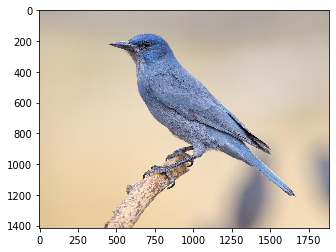

In [5]:
download_image(bird[0], bird[1])

img = Image.open(bird[1]).convert('RGB')
plt.imshow(img) 
plt.show()

# <font style="color:green">1. FCN with Resnet-101 backbone</font>

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

Get details of `FCN` [here](https://people.eecs.berkeley.edu/~shelhamer/data/fcn.pdf). 

Let's load one up!

In [6]:
fcn_resnet101 = models.segmentation.fcn_resnet101(pretrained=True).eval()

**Let's download a image**

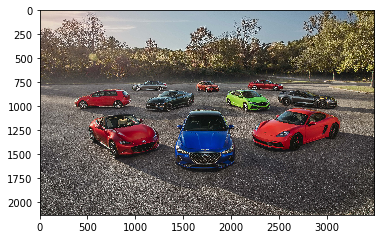

In [7]:
# download a image

cars = ('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg',
          'cars.jpg')


download_image(cars[0], cars[1])

img = Image.open(cars[1]).convert('RGB')
plt.imshow(img) 
plt.show()

**Let's do pre-process transformation and prepare like a batch input.**

In [8]:
# Apply the transformations needed
trf = T.Compose([T.Resize(640),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])

inp = trf(img).unsqueeze(0)

print('Image size after transformation: {}'.format(inp.size()))

Image size after transformation: torch.Size([1, 3, 640, 1047])


**Let's infer the model.**

In [9]:
# Pass the input through the net
out = fcn_resnet101(inp)['out']
print (out.shape)

torch.Size([1, 21, 640, 1047])


**Let's apply argmax along the dim=1 to get predicted labels for each pixel.**

In [10]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(640, 1047)
[0 7]


Alright! So, we as we can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [11]:
# Define the helper function
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),  # 0=background
    # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
    (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
    # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
    (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
    # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
  
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    
    return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list, 
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` 
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output!

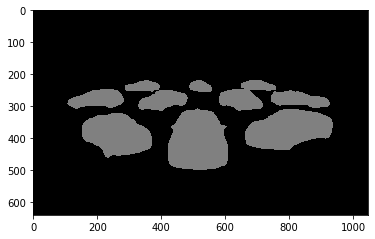

In [12]:
rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

And there we go!!<br/>
Wooohooo! We have segmented the output of the image. 


**Next, let's move all this under one function and play with a few more images!**

In [13]:
def segment(net, path, image_size=640, show_orig=True, dev='cpu'):
    img = Image.open(path).convert('RGB')
    
    if show_orig: 
        plt.imshow(img) 
        plt.axis('off'); plt.show()
        
    # resize image to 640
    trf = T.Compose([T.Resize(image_size), 
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
    
    inp = trf(img).unsqueeze(0)
    inp = inp.to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
    
    return

In [14]:
# download another image

cars = ('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg',
          'cars.jpg')


download_image(cars[0], cars[1])


In [15]:
cuda_device = 'cuda:0'

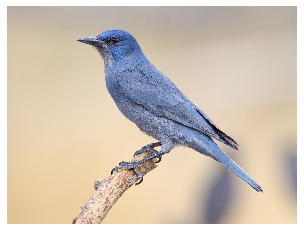

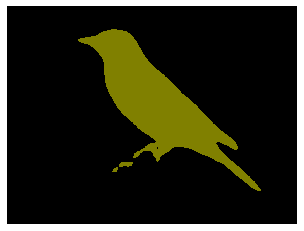

In [16]:
segment(net=fcn_resnet101, path=bird[1], dev=cuda_device)

# <font style="color:green">2. DeepLabv3</font>

Get details of `DeepLabv3` [here](https://arxiv.org/pdf/1706.05587.pdf).

In [17]:
deeplabv3_resnet101 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

**Let's see how we perform with the same image on this model!**

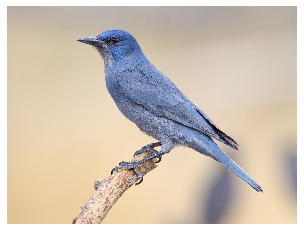

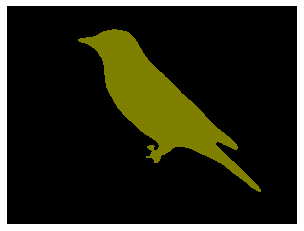

In [18]:
segment(net=deeplabv3_resnet101, path=bird[1], dev=cuda_device)

We can see that, the DeepLab model has also classified the image quite nicely!

**But if we take a more complex image! Then we start to see model differences!**

In [19]:
# tuple of image url and image name
moterbike = ("https://lh3.googleusercontent.com/-ELUnFgFJqUU/XPPXOOmhfMI/AAAAAAAAAP0/2cabsTI9uGUYxM3O3w4EOxjR_iJvEQAvACK8BGAs/s374/index3.png", 
             "moterbike.png")

download_image(moterbike[0], moterbike[1])

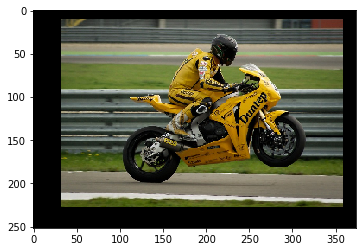

Segmenatation Image on FCN


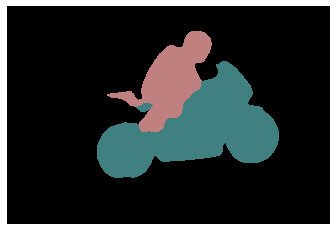

Segmenatation Image on DeepLabv3


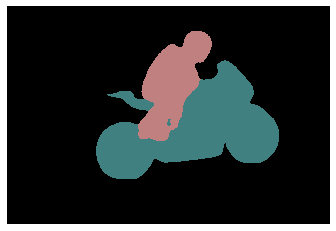

In [20]:
img = Image.open(moterbike[1]).convert('RGB')

plt.imshow(img)
plt.show()

print ('Segmenatation Image on FCN')
segment(fcn_resnet101, path=moterbike[1], show_orig=False, dev=cuda_device)

print ('Segmenatation Image on DeepLabv3')
segment(deeplabv3_resnet101, path=moterbike[1], show_orig=False, dev=cuda_device)

**Okay! You can now see the model differences right?**

**We can see that the FCN model labeled the motorbike back portion as a person; however, DeepLab identified is correct as a motorbike.**

# <font style="color:green">Infererence Speed Comprasion</font>

**Let's see the average inference of both models on CPU and GPU.**

In [21]:
def avg_infer_time(net, dev='cpu', infer_count=1000):
    
    random_image = torch.rand(1, 3, 244, 244).to(dev)
    net = net.to(dev)
    
    st_time = time.time()
    for i in range(infer_count):
        net(random_image)
        
    avg_time = (time.time() - st_time)/infer_count
        
    return avg_time

In [22]:
print('Average inference time for fcn_resnet101 on CPU: {}'.
      format(avg_infer_time(fcn_resnet101, 'cpu')))

Average inference time for fcn_resnet101 on CPU: 0.7059059138298035


In [23]:
print('Average inference time for deeplabv3_resnet101 on CPU: {}'.
      format(avg_infer_time(deeplabv3_resnet101, 'cpu')))

Average inference time for deeplabv3_resnet101 on CPU: 0.9932308673858643


In [24]:
print('Average inference time for fcn_resnet101 on GPU: {}'.
      format(avg_infer_time(fcn_resnet101, cuda_device)))

Average inference time for fcn_resnet101 on GPU: 0.02378885626792908


In [25]:
print('Average inference time for deeplabv3_resnet101 on GPU: {}'.
      format(avg_infer_time(deeplabv3_resnet101, cuda_device)))

Average inference time for deeplabv3_resnet101 on GPU: 0.03288957738876343
